# Machine Learning - Project

In [61]:
%pip install matplotlib
%pip install pandas
%pip install scikit-learn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 15.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 18.8 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.7 MB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.4-cp311-cp311-macosx_11_0_arm64.whl (63 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.8 MB/s eta 0:00:00a 0:00:01
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pytho

# Columns Definitions

Here is the meaning of every columns explain in `Xente_Variable_Definitions.csv`.

 * **TransactionId**: Unique transaction identifier on platform
 * **BatchId**: Unique number assigned to a batch of transactions for processing
 * **AccountId**: Unique number identifying the customer on platform
 * **SubscriptionId**: Unique number identifying the customer subscription
 * **CustomerId**: Unique identifier attached to Account
 * **CurrencyCode**: Country currency
 * **CountryCode**: Numerical geographical code of country
 * **ProviderId**: Source provider of Item bought.
 * **ProductId**: Item name being bought.
 * **ProductCategory**: ProductIds are organized into these broader product categories.
 * **ChannelId**: Identifies if customer used web,Android, IOS, pay later or checkout.
 * **Amount**: Value of the transaction. Positive for debits from customer account and negative for credit into customer account
 * **Value**: Absolute value of the amount
 * **TransactionStartTime**: Transaction start time
 * **PricingStrategy**: Category of Xente's pricing structure for merchants
 * **FraudResult**: Fraud status of transaction 1 -yes or 0-No


# Load training data

The first thing we do is to load the training data from `training.csv`.

In [55]:
training_data_path = './data/training.csv'

# Read data from file
training_data = pd.read_csv(training_data_path)

# Set the 'TransactionId' as index
training_data.set_index('TransactionId', inplace=True)

training_data.head(5)

,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
TransactionId,,,,,,,,,,,,,,,
TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


# Data analysis

Now that we have our data loaded, we will analyse the differents data in order the get the best possible model.

# Mutual Information

First thing first, we will look at the relationship between every columns and the target value.

In [56]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [58]:
# Define the datasets
X = training_data.copy()
y = X.pop('FraudResult')

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# Get the discrete features by checking that it is a int
discrete_features = X.dtypes == int

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores


BatchId                 0.074275
TransactionStartTime    0.013295
Amount                  0.012405
CustomerId              0.010441
AccountId               0.009381
SubscriptionId          0.008925
Value                   0.008771
ProductId               0.005996
ProviderId              0.003640
PricingStrategy         0.002351
ProductCategory         0.002178
ChannelId               0.000358
CurrencyCode            0.000000
CountryCode             0.000000
Name: MI Scores, dtype: float64

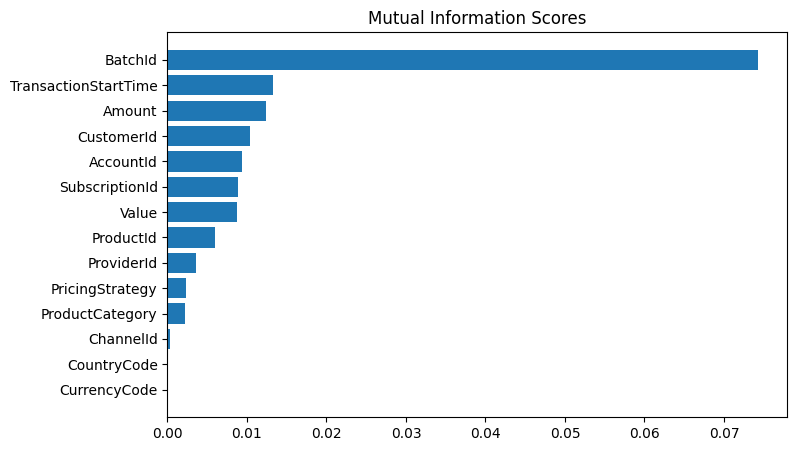

In [62]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

As we can see in the plot, the `BatchId` is the most dominant columns. But we cannot take this one into account as it is a biased value due to the fact the the `BatchId`is only an identification for the transaction.

Same for `CustomerId`, `AccountId` and `SubscriptionId`, because they refers to customers. We do not want to predict a fraud based on the customers habits.

Based on what have been said before, here is the new Mutual Information removing the following columns: `BatchId`, `CustomerId`, `AccountId` and `SubscriptionId`.

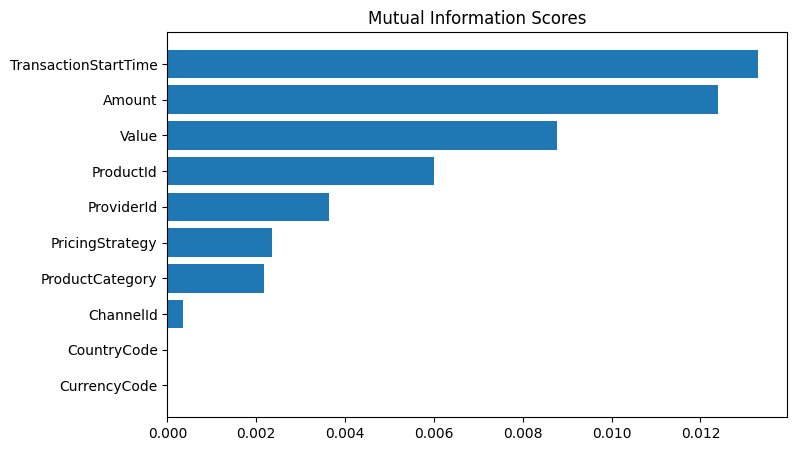

In [65]:
# Define columns to remove
ColsToRemove = ['BatchId', 'CustomerId', 'AccountId', 'SubscriptionId']

# Remove useless columns
mi_scores.drop(ColsToRemove, inplace=True)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

## Transaction country

First, we will attack with the columns `CurrencyCode` and `CountryCode`. Actually, they point to the same thing: from which country the transaction has been done. Thus, we can say that having both columns is redundant to estimate our model prediction.

We will first look at the occurence of every country and then check its relationship with the target value.

In [20]:
# Load CurrencyCode and CountryCode
X_CurrencyCode = training_data['CurrencyCode']
X_CountryCode = training_data['CountryCode']

# Count occurence of each rows
CurrencyCode_Occurences = X_CurrencyCode.value_counts()
CountryCode_Occurences = X_CountryCode.value_counts()

# Show information
print(CurrencyCode_Occurences)
print('\n---\n')
print(CountryCode_Occurences)

CurrencyCode
UGX    95662
Name: count, dtype: int64

---

CountryCode
256    95662
Name: count, dtype: int64


As we can see, `CurrencyCode` and `CountryCode` has only one distinct value in all the dataset. Give that, we can say that this columns will not give any additional information to our model.

Based on the Mutual Information calculated above, we can see than `CurrencyCode` and `CountryCode` are independent variables.

## Transaction Start Time

As information, we have `TransactionStartTime` and it is the transaction start time. It is written using the [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601) date format. In this form, we cannot exploit the data in our model.

From the date, we can take some interesting information such as:
 * Day of the week
 * Month
 * Period of the year

By retrieving this information, we can try to visualise if the fraud is something periodically, that happens on certain week day, ...

Given that, our first step will be to preprocessing our data and create 2 new columns: `TransactionWeekDay` and `TransactionMonth.`

 * **TransactionWeekDay**: 0 - 6
 * **TransactionMonth**: 0 - 11

In [105]:
from datetime import datetime

def date_to_weekday_month(row):
    # Create datetime object from the ISO date
    row_date = datetime.fromisoformat(row['TransactionStartTime'])
    
    # Add the week and month into the data
    row['TransactionWeekDay'] = row_date.weekday()
    row['TransactionMonth'] = row_date.month

    return row

In [106]:
# Retrieve the transaction date from the training datasets
TransactionStartTime = training_data[['TransactionStartTime']]

# Apply the function on every row
TransactionStartTimeDetails = TransactionStartTime.apply(date_to_weekday_month, axis=1)

TransactionStartTimeDetails.head()

,TransactionStartTime,TransactionWeekDay,TransactionMonth
TransactionId,,,
TransactionId_76871,2018-11-15T02:18:49Z,3,11
TransactionId_73770,2018-11-15T02:19:08Z,3,11
TransactionId_26203,2018-11-15T02:44:21Z,3,11
TransactionId_380,2018-11-15T03:32:55Z,3,11
TransactionId_28195,2018-11-15T03:34:21Z,3,11


## Mutual information for Month and Week day

Now that we have the information about `TransactionWeekDay` and `TransactionMonth`, we can compute their Mutual Information.

In [112]:
# Define the variable to check the relationship
X = TransactionStartTimeDetails[['TransactionMonth', 'TransactionWeekDay']]
y = training_data['FraudResult']

# Get the discrete features just to be sure
discrete_features = X.dtypes == int
print(discrete_features)

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

TransactionMonth      True
TransactionWeekDay    True
dtype: bool


TransactionWeekDay    0.000811
TransactionMonth      0.000050
Name: MI Scores, dtype: float64

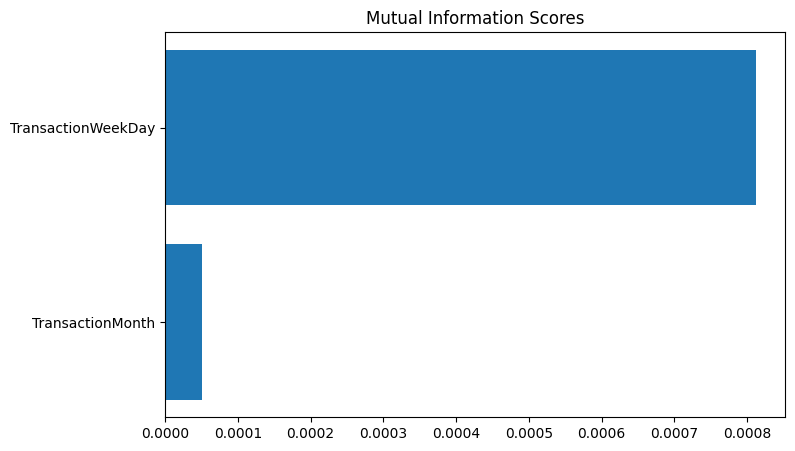

In [113]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

## Categorise the data

Now we are going the categorise our discrete value. We will apply a One-Hot Encoder on `ProductCategory` and `ChannelId`.

As a reminder, a One-Hot Encoder will create new binary columns, indicating the presence of each possible values from the original data.

![One-Hot Encoding](./pictures/one-hot-encoding.png)

One-Hot Encoding works well when the categorical variable takes on a small number of values (15 regarding [Kaggle](https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding)).

We will then check the number of unique categories in every one of our columns, and apply One-Hot Encoding if the distinct values is less than `15`.


In [27]:
# Define the columns to categorise
CategoriseCols = ['ProductCategory', 'ChannelId']

# Extract our categorical variable
CategoricalVariable = training_data.loc[:, CategoriseCols]

# Get number of unique values in each column
CategoricalVariable.nunique()

ProductCategory    9
ChannelId          4
dtype: int64

As we can see, `ProductCategory` has 9 distincts values and `ChannelId`has 4. We can then apply One-Hot Encoding on each column.

In [24]:
from sklearn.preprocessing import OneHotEncoder

# Define the columns to categorise
CategoriseCols = ['ProductCategory', 'ChannelId']

# Define One-Hot Encoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Apply encoder to the ProductCategory column
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(training_data[CategoriseCols]))

OH_cols_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
